# Classifying disputed Federalist papers
The goal here is based on the authors of the known federalist papers, classifiy the unknown ones using a model

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/papers.csv'
df = pd.read_csv(url)

df.head()
#the goal is classifie the disputed federalist papers, what are the authors of those twelve given the other ones

,paper,author
0,To the People of the State of New York: AFTE...,Hamilton
1,To the People of the State of New York: WHEN...,Jay
2,To the People of the State of New York: IT I...,Jay
3,To the People of the State of New York: MY L...,Jay
4,To the People of the State of New York: QUEE...,Jay


In [2]:
import gensim.downloader as api
emb = api.load('glove-wiki-gigaword-50')

In [3]:
df['author'].value_counts()

author
Hamilton            51
Madison             14
Disputed            12
Jay                  5
Hamilton+Madison     3
Name: count, dtype: int64

In [4]:
df['paper'].size
import numpy as np


# PREPROCESSING THE DATA

The general process will be as follows:

First each paper will be embedded per word.

Then each paper will be divided up into some number of chunks such that each chunk has N words (now vectorized).

For each chunk, the vectorized words will me sumed up to calcuate there mean, this will be the new vector for that 'chunk'.

Along side this we make sure to record what author wrote each 'chunk'.

Finally we will tokenize the authorizes with numbers and remove the papers that were writen by Jay and madison+hamilton (they account for 8 of them, so they dont really matter to us here).

This will be the form in which the data exists when we use our model on it.


In [5]:
#==============
# made this into a function beacuse i may want to repeat this with different number of words
# takes in the data set, embeds it, then splits each paper into chunks of a set size,
# then makes sure theirs labels for all the chunks, and turns those labels into numbers
# finally splits into training and testing sets (testing being the disputed papers)
#==============
def prepare_data(df,num_words_per_chunk):
    vectorized_text = []
    for text in df['paper']:
        text_vector = np.array([emb[word] for word in text if word in emb])
        vectorized_text.append(text_vector)
    vectorized_text_np = np.array(vectorized_text, dtype=list) 
    #this is the dataset, with each word embedded 
    
    NUM_WORDS_PER_CHUNK = num_words_per_chunk #this sets how many words per chunk that we will mean across
    
    #======
    #now we will divide each text into equal sized chunks for the imbedded words
    divided_vectorized_text = [] 
    number_of_chunks_per_paper = []
    for text in vectorized_text_np:
        l = len(text)
        size_ratio = l/NUM_WORDS_PER_CHUNK #number of chunks to divide the text into
        divided_sentences = np.array_split(text,size_ratio)
        number_of_sentences_created = len(divided_sentences) #this will be for reconstruction later
        number_of_chunks_per_paper.append(number_of_sentences_created)
        divided_vectorized_text.append(divided_sentences)
        
    divided_vectorized_text_np = np.array(divided_vectorized_text,dtype=list)
    # this is the dataset, with each text now being divied into size_ratio number of chunks of equal size
    
    #======
    final_text = []
    final_text_labels = []
    iter = 0
    for chunked_text in divided_vectorized_text_np: #now we flatten manuelly while also geting the labels
        author = df['author'].iloc[iter]
        for chunk in chunked_text: #we sum each chunk of words into a averaged vector for that chunk of words and assgin it a author 
            vec_mean = np.mean(chunk,axis=0)
            final_text.append(vec_mean)
            final_text_labels.append(author)
        iter +=1
    X = np.array(final_text)
    y = np.array(final_text_labels)
    #=================== #encoding the values with numbers for classification
    y_numbers = [] 
    for name in y:
        value = 0
        if name == "Hamilton":
            value = 1
            y_numbers.append(value)
        elif name == "Madison":
            value = 2
            y_numbers.append(value)
        elif name == "Disputed":
            value = 3
            y_numbers.append(value)
        elif name == "Jay":
            value = 4
            y_numbers.append(value)
        elif name == "Hamilton+Madison":
            value = 5
            y_numbers.append(value)
        
    y_numbers = np.array(y_numbers)
    disputed_indices = np.where(y == "Disputed")
    disputed_indices = np.array(disputed_indices)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for index in range(len(X)):
        #if in the disputed
        if index in disputed_indices:
            X_test.append(X[index])
            y_test.append(y_numbers[index])
        else: #not in the disputed
            X_train.append(X[index])
            y_train.append(y_numbers[index])
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    #======
    #now making it a binary classificaiton comment this out to retrun to multiclass
    remove_indices = np.where((y_train == 4) | (y_train == 5))[0] #this is failing 
    X_train = np.delete(X_train,remove_indices, axis=0)
    y_train = np.delete(y_train,remove_indices)
    #======
    #now getting the number of chunks in each of the disputed papers
    lengths_of_disputed = []
    iter = 0
    for author in df['author']:
        if author == 'Disputed':
            length_of_pap = number_of_chunks_per_paper[iter]
            lengths_of_disputed.append(length_of_pap)
        iter+=1

    return X_train, X_test, y_train, y_test, number_of_chunks_per_paper, lengths_of_disputed 
    

In [6]:
def reconstruct_disputed_preds(preds,lengths_of_disputed): #reconstructs the individual texts and puts then together again
    sub_arrays = []
    previous_index = 0
    for length in lengths_of_disputed:
        text = preds[previous_index:previous_index+length]
        previous_index += length
        sub_arrays.append(text)
    return(sub_arrays)

def reconstruct_classification(sub_array_preds):
    final_predictions = []
    for preds in sub_array_preds:
        counts = np.bincount(preds)
        majority_pred = np.argmax(counts)
        final_predictions.append(majority_pred)
    return final_predictions
        

In [7]:
X_train,X_test,y_train,y_test, number_of_chunks_per_paper, lengths_of_disputed = prepare_data(df,30)

*Some notes on my methods:*
Because each paper is being split into some number of chunks, those chunks will have to be recombined to achieve a final paper prediction,(hence the reconstruction functinos defined above) to achieve this once i have a perdiction for each chunk, im going to have whichever label has the magority between the two be the final prediction.

AND NOTE: MADISON = 2, AND HAMILTON = 1


*Some Notes of what i did with models:*
For each model i displayed the Confusion matrix and the precision recall curve (as threshold is varied) to educate my guesses as to what a good threshold would be by trying to max the precision and recall values while also maintaining realistic values, while also using grid search to get good values for the model itself.

# Model 1 Random forest with a size of 30 words per vector

In [8]:
from sklearn.model_selection import train_test_split
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train,y_train)

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_clf_2 = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV

param_dic = {
    'n_estimators': range(20,100),
    'max_depth': range(2,10),
    'min_samples_split': range(10,100), #the metrics used for random forest reg
    'min_samples_leaf': range(5,100)
}
grid = RandomizedSearchCV(rf_clf_2,
                          param_dic,
                          n_iter=50,
                          scoring='average_precision',
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train_train,y_train_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_samples_leaf': range(5, 100),
                                        'min_samples_split': range(10, 100),
                                        'n_estimators': range(20, 100)},
                   scoring='average_precision')

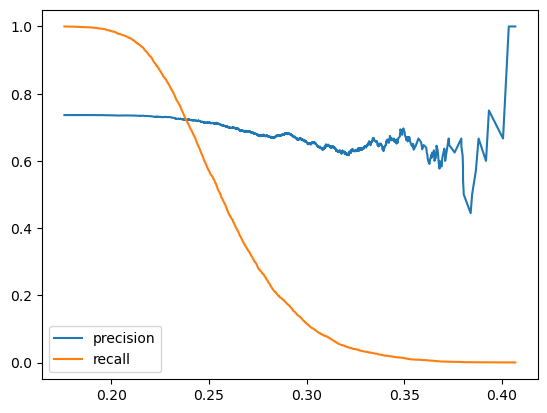

In [10]:
#PLOTTING THE PRECISION RECALL CURVE TO FIND IDEAL THRESHOLD VALUE
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_test_proba = grid.predict_proba(X_train_valid)[:,1]
precision, recall, threshold = precision_recall_curve(y_train_valid,y_test_proba,pos_label=1)
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()

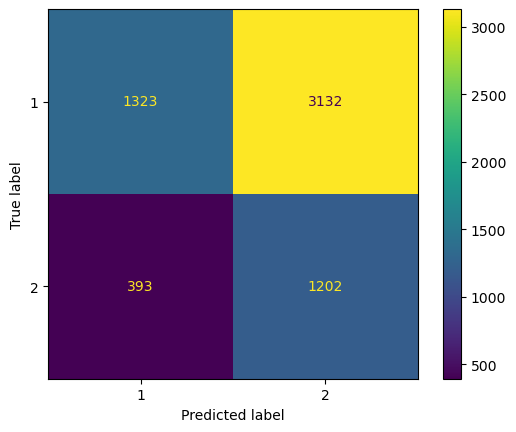

In [11]:
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.metrics import accuracy_score
# SETTING THE THRESHOLD VALUE
threshold = .24
final_model = FixedThresholdClassifier(grid,threshold=threshold) 
y_pred = final_model.predict(X_train_valid)
# USING THE PREDICTIONS OF THE MODEL, NOW DISPLAY THE CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_valid, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)
disp.plot()

In [12]:
print(accuracy_score(y_train_valid,y_pred))

0.41735537190082644


In [13]:
reconstructed_preds = reconstruct_disputed_preds(y_pred,lengths_of_disputed)
final_preds = reconstruct_classification(reconstructed_preds)
final_preds

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2)]

By and large this model performed not so good, with a low accuracy score and a rather bad confusion matrix.

However i do not want to continue to drive the threshold up because the threshold i selected is about around what gives the best combo of precision and recall while also being a realistic value. If i were to do so, all papers would be attributed to hamilton because he has written a vast magority of the ones we do have. However for future models i may experemenit with different thresholds, because i sort of know the actual test labels (modern theories say that madsion wrote the disputed ones).

So in the end this model decalares all were written by Madison.

# Model 2: Random Forest with size 20 per vector

In [14]:
X_train,X_test,y_train,y_test, number_of_chunks_per_paper, lengths_of_disputed = prepare_data(df,20)
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train,y_train)

In [15]:
rf_clf_2 = RandomForestClassifier()
param_dic = {
    'n_estimators': range(20,100),
    'max_depth': range(2,10),
    'min_samples_split': range(10,100), #the metrics used for random forest reg
    'min_samples_leaf': range(5,100)
}
grid = RandomizedSearchCV(rf_clf_2,
                          param_dic,
                          n_iter=50,
                          scoring='average_precision',
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train_train,y_train_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_samples_leaf': range(5, 100),
                                        'min_samples_split': range(10, 100),
                                        'n_estimators': range(20, 100)},
                   scoring='average_precision')

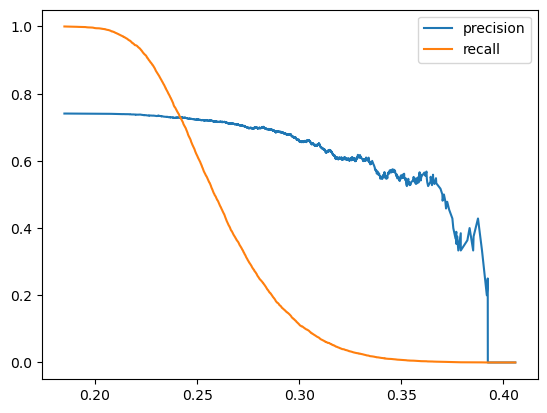

In [16]:
y_test_proba = grid.predict_proba(X_train_valid)[:,1]
precision, recall, threshold = precision_recall_curve(y_train_valid,y_test_proba,pos_label=1)
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()

0.474721885670228


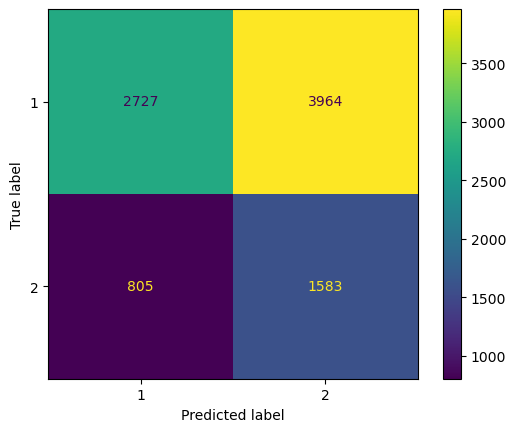

In [30]:
# SETTING THE THRESHOLD VALUE
threshold = .25
final_model = FixedThresholdClassifier(grid,threshold=threshold) 
y_pred = final_model.predict(X_train_valid)
# USING THE PREDICTIONS OF THE MODEL, NOW DISPLAY THE CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_valid, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)
disp.plot()
print(accuracy_score(y_train_valid,y_pred))

In [31]:
reconstructed_preds = reconstruct_disputed_preds(y_pred,lengths_of_disputed)
final_preds = reconstruct_classification(reconstructed_preds)
final_preds

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2)]

Exception ignored in: <function ResourceTracker.__del__ at 0x1028e07c0>
Traceback (most recent call last):
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10342c7c0>
Traceback (most recent call last):
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/noahwanless/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in

Performance was basically the same as with 30 words (44 and 54 percent accuracy are equally poor), i also messed around with the threshold to find increasing it much more caused it to predict madison a lot less, and also to only predict hamilton for the test case, which we know shouldnt really be the case, this seemed to be the best middle ground.

In the end this model predicts Madison for all 

# Model 3, Once again Random Forest, but this time with 10 words per vector

In [19]:
X_train,X_test,y_train,y_test, number_of_chunks_per_paper, lengths_of_disputed = prepare_data(df,10)
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train,y_train)

In [20]:
rf_clf_2 = RandomForestClassifier()
param_dic = {
    'n_estimators': range(20,100),
    'max_depth': range(2,10),
    'min_samples_split': range(10,100), #the metrics used for random forest reg
    'min_samples_leaf': range(5,100)
}
grid = RandomizedSearchCV(rf_clf_2,
                          param_dic,
                          n_iter=50,
                          scoring='average_precision',
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train_train,y_train_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_samples_leaf': range(5, 100),
                                        'min_samples_split': range(10, 100),
                                        'n_estimators': range(20, 100)},
                   scoring='average_precision')

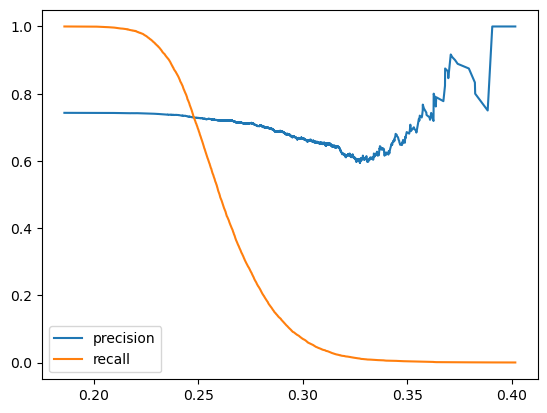

In [21]:
y_test_proba = grid.predict_proba(X_train_valid)[:,1]
precision, recall, threshold = precision_recall_curve(y_train_valid,y_test_proba,pos_label=1)
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()

0.4305295607178245


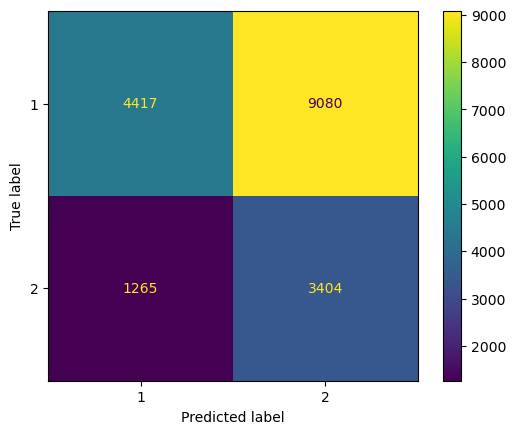

In [22]:
# SETTING THE THRESHOLD VALUE
threshold = .251
final_model = FixedThresholdClassifier(grid,threshold=threshold) 
y_pred = final_model.predict(X_train_valid)
# USING THE PREDICTIONS OF THE MODEL, NOW DISPLAY THE CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_valid, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)
disp.plot()
print(accuracy_score(y_train_valid,y_pred))

In [23]:
reconstructed_preds = reconstruct_disputed_preds(y_pred,lengths_of_disputed)
final_preds = reconstruct_classification(reconstructed_preds)
final_preds

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2)]

It seems that the number of words in one vector makes little difference as to the performance of the word. (At least keeping thing contained to the 10-30 range, which i think is a good range) so which one you pick seems to not matter. Regardless the outcome is the same, all papers were assgined to madison, which makes sense give the historical knowledge we have and the offical resurch that has been done

# Model 4 Logistic regression

In [24]:
X_train,X_test,y_train,y_test, number_of_chunks_per_paper, lengths_of_disputed = prepare_data(df,20)
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train,y_train)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_dic = {
    "C":[.01,.1,.05,.25,.5,1,10,100,200,300],
}
grid = GridSearchCV(LogisticRegression(max_iter=1000),
                          param_dic,
                          scoring='accuracy',
                          verbose = 1, 
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.05, 0.25, 0.5, 1, 10, 100, 200,
                               300]},
             scoring='accuracy', verbose=1)

In [26]:
print(grid.best_params_)
y_pred = grid.predict(X_test)
unique_values, counts = np.unique(y_pred, return_counts=True)
unique_values

{'C': 1}


array([1])

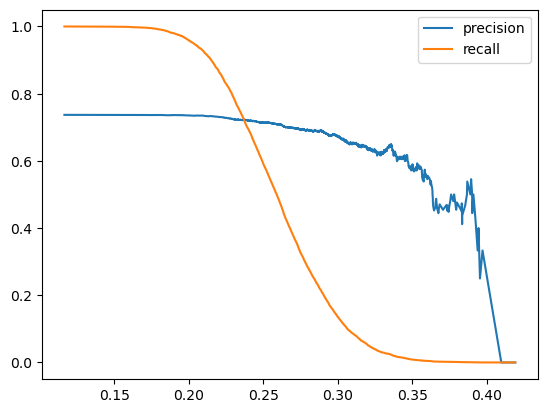

In [27]:
y_test_proba = grid.predict_proba(X_train_valid)[:,1]
precision, recall, threshold = precision_recall_curve(y_train_valid,y_test_proba,pos_label=1)
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()

0.46502918823658995


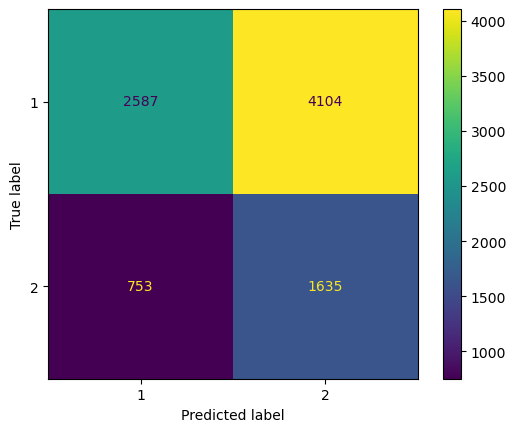

In [28]:
# SETTING THE THRESHOLD VALUE
threshold = .248
final_model = FixedThresholdClassifier(grid,threshold=threshold) 
y_pred = final_model.predict(X_train_valid)
# USING THE PREDICTIONS OF THE MODEL, NOW DISPLAY THE CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_valid, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)
disp.plot()
print(accuracy_score(y_train_valid,y_pred))

In [29]:
reconstructed_preds = reconstruct_disputed_preds(y_pred,lengths_of_disputed)
final_preds = reconstruct_classification(reconstructed_preds)
final_preds

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2)]

Once again about the same conclusion, all papers are attributed to madison.

# Final Thoughts (All are written by Madison is my final conclusion)

After some experimentation i found that increasing the threshold values on the various models much more then i already had them set at would cause the model to simply never predict madison (or at least never in any consequencal fashion), and it caused the final test predictions, (which we guess should predict madison) to not predict madison for any of those, so i left the thresholds roughly where they were.

So my final guess would be that ALL the disputed papers were written by madison. With a chance that one or two of the later ones might have been made by Hamilton (at times while tuning the threshold across all the models some of these would switch to hamilton, but small changes to the threshold would get rid of those predictions settling back to madison) but not enough of a chance to guess otherwise

In the end while the models performances were subpar to say the least, i think it worked, ok, and sometimes ok is enough. Regardless I somewhat predicted the things correctly 